# Processing of SCIP features

SCIP features have been computed on EhV data form the first large scale experiment, on files: H1_T7, H1_T8, H1_T9, H2_T7, H2_T8, H2_T9

## Load raw split frame

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load ../common_.py
import sys
sys.path.append("..")
from common import *

In [3]:
from ehv.core import plot_gate_zarr

In [4]:
import pyarrow.parquet as pq
import pyarrow

## Load data

In [7]:
data_dir = Path("/data/gent/vo/000/gvo00070/vsc42015/datasets/wbc/results/scip/202204271347")

In [6]:
df = pandas.concat([
    pq.read_table(p).to_pandas()
    for p in data_dir.glob("*.parquet")
], axis=0)

In [8]:
df["meta_sample"] = df["meta_path"].apply(lambda p: Path(p).stem[:-8])

In [10]:
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

pop_dir = data_dir / "meta/"
pop_files = list(Path(pop_dir).glob("*.pop"))
pops = {}
for sample in df["meta_sample"].unique():
    pops[sample] = {}

    for f in pop_files:
        if f.name.startswith(sample):
            pop_file = f
            with open(pop_file, "r") as fh:
                content = fh.read()
                if len(content) > 0:
                    indices = content[:-2].replace("\n", "").replace(" ", "").strip().split(",")
                    for idx in indices:
                        if ("early" in pop_file.stem) or ("late" in pop_file.stem):
                            pops[sample][int(idx)] = pop_file.stem[find_nth(pop_file.stem, "_", 3)+1:]
                        else:
                            pops[sample][int(idx)] = pop_file.stem[find_nth(pop_file.stem, "_", 2)+1:]

In [11]:
def map_to_class(x):
    try:
        s = pops[x.meta_sample]
        return s[x.meta_object_number]
    except:
        return "unknown"

In [12]:
df["meta_label"] = "unknown"
chunk_size = len(df)//10 + 1
for i in range(0, 10):
    df.iloc[i*chunk_size:(i+1)*chunk_size, df.columns.get_loc("meta_label")] = df.iloc[i*chunk_size:(i+1)*chunk_size].apply(map_to_class, axis=1)
    print(i)

0
1
2
3
4
5
6
7
8
9


In [8]:
df = pq.read_table(data_dir / "features.parquet").to_pandas()

In [10]:
df.shape

(274050, 2519)

In [20]:
df[df["meta_group"].isin(['3', '4']) & (df["meta_fix"] == "early")].shape

(104597, 2519)

<AxesSubplot:xlabel='count', ylabel='meta_group'>

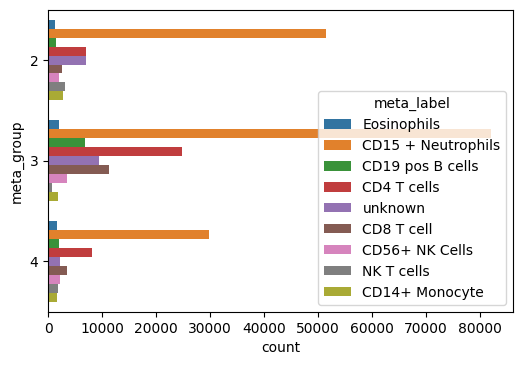

In [11]:
fig, ax = plt.subplots(dpi=100)
seaborn.countplot(ax=ax, data=df, y="meta_group", hue="meta_label")

In [14]:
df["meta_label"].value_counts()

CD15 + Neutrophils    163421
CD4 T cells            39840
unknown                18560
CD8 T cell             17282
CD19 pos B cells       10438
CD56+ NK Cells          7744
CD14+ Monocyte          6207
NK T cells              5775
Eosinophils             4783
Name: meta_label, dtype: int64

In [15]:
df.shape

(274050, 2519)

In [16]:
df = df.reset_index(drop=True)

In [19]:
pq.write_table(
    pyarrow.Table.from_pandas(df), data_dir / "results/scip/202204271347/features.parquet")